<a href="https://colab.research.google.com/github/TTB-gif/-TTB-gif--DataScience-GenAI-Submissions/blob/main/5_02_Modelling_Hackathon.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

![](https://drive.google.com/uc?export=view&id=1xqQczl0FG-qtNA2_WQYuWePW9oU8irqJ)

# 5.02 Modelling Hackathon
We'll get a chance in this seminar to practice for the in-class test, and also to put what we have learned into practice.

To speed things up, I have done the data/feature engineering for you, you will just need to build it into a data science model. As before, you can use the code from [GitHub](https://github.com/MJMortensonWarwick/IB2AD0_Data_Science_GenerativeAI), from the internet, and/or use the Gemini AI tools.

This is an artificial dataset, and we will be predicting if students achieve a passing grade, which we will call anything above a "D".

We'll start by importing the data:

In [1]:
from google.colab import files
upload = files.upload()

Saving students_two.csv to students_two.csv


Now we will get the data into Pandas and inspect it:

In [2]:
import pandas as pd
df = pd.read_csv("students_two.csv")

df.head()

,Id,Student_Age,High_School_Type,Scholarship,Additional_Work,Sports_activity,Transportation,Weekly_Study_Hours,Attendance,Reading,Notes,Listening_in_Class,Project_work,Grade
0,5001,21,Other,50%,Yes,No,Private,0,Always,Yes,Yes,No,No,AA
1,5002,20,Other,50%,Yes,No,Private,0,Always,Yes,No,Yes,Yes,AA
2,5003,21,State,50%,No,No,Private,2,Never,No,No,No,Yes,AA
3,5004,18,Private,50%,Yes,No,Bus,2,Always,No,Yes,No,No,AA
4,5005,22,Private,50%,No,No,Bus,12,Always,Yes,No,Yes,Yes,AA


Let's check for missing values:

In [3]:
df.isnull().sum()

,0
Id,0
Student_Age,0
High_School_Type,0
Scholarship,1
Additional_Work,0
Sports_activity,0
Transportation,0
Weekly_Study_Hours,0
Attendance,0
Reading,0


Only one missing value. Let's just drop it out of laziness:

In [4]:
df.dropna(inplace=True)
df.isnull().sum()

,0
Id,0
Student_Age,0
High_School_Type,0
Scholarship,0
Additional_Work,0
Sports_activity,0
Transportation,0
Weekly_Study_Hours,0
Attendance,0
Reading,0


We have an ID column we know won't be predictive ... so let's drop it:

In [5]:
df = df.drop(["Id"], axis=1)
df.head()

,Student_Age,High_School_Type,Scholarship,Additional_Work,Sports_activity,Transportation,Weekly_Study_Hours,Attendance,Reading,Notes,Listening_in_Class,Project_work,Grade
0,21,Other,50%,Yes,No,Private,0,Always,Yes,Yes,No,No,AA
1,20,Other,50%,Yes,No,Private,0,Always,Yes,No,Yes,Yes,AA
2,21,State,50%,No,No,Private,2,Never,No,No,No,Yes,AA
3,18,Private,50%,Yes,No,Bus,2,Always,No,Yes,No,No,AA
4,22,Private,50%,No,No,Bus,12,Always,Yes,No,Yes,Yes,AA


Next we will convert some of the text features to numbers:

In [6]:
# High school
print(df['High_School_Type'].unique())

['Other' 'State' 'Private']


We can't easily convert these to a number range. Instead we should use one-hot encoding:

In [7]:
df = pd.get_dummies(df, columns=['High_School_Type'], drop_first=True, dtype=int)
df.head()

,Student_Age,Scholarship,Additional_Work,Sports_activity,Transportation,Weekly_Study_Hours,Attendance,Reading,Notes,Listening_in_Class,Project_work,Grade,High_School_Type_Private,High_School_Type_State
0,21,50%,Yes,No,Private,0,Always,Yes,Yes,No,No,AA,0,0
1,20,50%,Yes,No,Private,0,Always,Yes,No,Yes,Yes,AA,0,0
2,21,50%,No,No,Private,2,Never,No,No,No,Yes,AA,0,1
3,18,50%,Yes,No,Bus,2,Always,No,Yes,No,No,AA,1,0
4,22,50%,No,No,Bus,12,Always,Yes,No,Yes,Yes,AA,1,0


We have converted this to two columns (on the far right) - "High_School_Type_Private" and "High_School_Type_State". We do not need the "Other" type as if the student is "Other" then both "Private" and "State" will be 0 (a unique combination). This is controlled by the command _drop\_first=True_. We also specify the data type (_dtype_) as __int__ so we return 0s and 1s rather than True and False.

Next we can look at Scholarship. It needs to be converted from a text representation of a percentage to a number:

In [8]:
df['Scholarship'] = df['Scholarship'].str.replace('%', '').astype(float) / 100
df.head()

,Student_Age,Scholarship,Additional_Work,Sports_activity,Transportation,Weekly_Study_Hours,Attendance,Reading,Notes,Listening_in_Class,Project_work,Grade,High_School_Type_Private,High_School_Type_State
0,21,0.5,Yes,No,Private,0,Always,Yes,Yes,No,No,AA,0,0
1,20,0.5,Yes,No,Private,0,Always,Yes,No,Yes,Yes,AA,0,0
2,21,0.5,No,No,Private,2,Never,No,No,No,Yes,AA,0,1
3,18,0.5,Yes,No,Bus,2,Always,No,Yes,No,No,AA,1,0
4,22,0.5,No,No,Bus,12,Always,Yes,No,Yes,Yes,AA,1,0


"Additional_Work" is next:

In [9]:
# Additional work
print(df['Additional_Work'].unique())

['Yes' 'No']


Two values, so we can convert to 0 and 1:

In [10]:
df['Additional_Work'] = df['Additional_Work'].map({'Yes': 1, 'No': 0})
df.head()

,Student_Age,Scholarship,Additional_Work,Sports_activity,Transportation,Weekly_Study_Hours,Attendance,Reading,Notes,Listening_in_Class,Project_work,Grade,High_School_Type_Private,High_School_Type_State
0,21,0.5,1,No,Private,0,Always,Yes,Yes,No,No,AA,0,0
1,20,0.5,1,No,Private,0,Always,Yes,No,Yes,Yes,AA,0,0
2,21,0.5,0,No,Private,2,Never,No,No,No,Yes,AA,0,1
3,18,0.5,1,No,Bus,2,Always,No,Yes,No,No,AA,1,0
4,22,0.5,0,No,Bus,12,Always,Yes,No,Yes,Yes,AA,1,0


Let's speed up now:

In [11]:
categorical_cols = ['Sports_activity', 'Transportation', 'Attendance', 'Reading', 'Notes', 'Listening_in_Class', 'Project_work', 'Grade']

for col in categorical_cols:
    print(f"Unique values for '{col}': {df[col].unique()}")

Unique values for 'Sports_activity': ['No' 'Yes']
Unique values for 'Transportation': ['Private' 'Bus']
Unique values for 'Attendance': ['Always' 'Never' 'Sometimes' '3']
Unique values for 'Reading': ['Yes' 'No']
Unique values for 'Notes': ['Yes' 'No' '6']
Unique values for 'Listening_in_Class': ['No' 'Yes' '6']
Unique values for 'Project_work': ['No' 'Yes']
Unique values for 'Grade': ['AA' 'BA' 'CC' 'Fail' 'BB' 'CB' 'DD' 'DC']


The values of '6' in 'Notes' and 'Listening_in_Class' make no sense, and neither do '3' for 'Attendance'. We'll be lazy and drop these rows (really we should check with an SME):

In [12]:
df = df[(df['Notes'] != '6') & (df['Listening_in_Class'] != '6') & (df['Attendance'] != '3')]
df.head()

,Student_Age,Scholarship,Additional_Work,Sports_activity,Transportation,Weekly_Study_Hours,Attendance,Reading,Notes,Listening_in_Class,Project_work,Grade,High_School_Type_Private,High_School_Type_State
0,21,0.5,1,No,Private,0,Always,Yes,Yes,No,No,AA,0,0
1,20,0.5,1,No,Private,0,Always,Yes,No,Yes,Yes,AA,0,0
2,21,0.5,0,No,Private,2,Never,No,No,No,Yes,AA,0,1
3,18,0.5,1,No,Bus,2,Always,No,Yes,No,No,AA,1,0
4,22,0.5,0,No,Bus,12,Always,Yes,No,Yes,Yes,AA,1,0


Now we can convert all those "Yes" / "No" columns to 0 and 1.

In [13]:
binary_cols = ['Sports_activity', 'Reading', 'Notes', 'Listening_in_Class', 'Project_work']

for col in binary_cols:
    df[col] = df[col].map({'Yes': 1, 'No': 0})

df.head()

,Student_Age,Scholarship,Additional_Work,Sports_activity,Transportation,Weekly_Study_Hours,Attendance,Reading,Notes,Listening_in_Class,Project_work,Grade,High_School_Type_Private,High_School_Type_State
0,21,0.5,1,0,Private,0,Always,1,1,0,0,AA,0,0
1,20,0.5,1,0,Private,0,Always,1,0,1,1,AA,0,0
2,21,0.5,0,0,Private,2,Never,0,0,0,1,AA,0,1
3,18,0.5,1,0,Bus,2,Always,0,1,0,0,AA,1,0
4,22,0.5,0,0,Bus,12,Always,1,0,1,1,AA,1,0


We can also do this with "Transportation":

In [14]:
df['Transportation'] = df['Transportation'].map({'Private': 1, 'Bus': 0})
df.head()

,Student_Age,Scholarship,Additional_Work,Sports_activity,Transportation,Weekly_Study_Hours,Attendance,Reading,Notes,Listening_in_Class,Project_work,Grade,High_School_Type_Private,High_School_Type_State
0,21,0.5,1,0,1,0,Always,1,1,0,0,AA,0,0
1,20,0.5,1,0,1,0,Always,1,0,1,1,AA,0,0
2,21,0.5,0,0,1,2,Never,0,0,0,1,AA,0,1
3,18,0.5,1,0,0,2,Always,0,1,0,0,AA,1,0
4,22,0.5,0,0,0,12,Always,1,0,1,1,AA,1,0


For Attendance an ordinal range makes sense:

In [15]:
df['Attendance'] = df['Attendance'].map({'Never': 0, 'Sometimes': 1, 'Always': 2})
df.head()

,Student_Age,Scholarship,Additional_Work,Sports_activity,Transportation,Weekly_Study_Hours,Attendance,Reading,Notes,Listening_in_Class,Project_work,Grade,High_School_Type_Private,High_School_Type_State
0,21,0.5,1,0,1,0,2,1,1,0,0,AA,0,0
1,20,0.5,1,0,1,0,2,1,0,1,1,AA,0,0
2,21,0.5,0,0,1,2,0,0,0,0,1,AA,0,1
3,18,0.5,1,0,0,2,2,0,1,0,0,AA,1,0
4,22,0.5,0,0,0,12,2,1,0,1,1,AA,1,0


This just leaves the target - 'Grade'. To make the problem binary we'll convert 'Fail' and any grade that includes a 'D' as 0 (for fail) and the rest as 1 (pass):

In [16]:
df['Grade'] = df['Grade'].apply(lambda x: 0 if x == 'Fail' or 'D' in x else 1)
df.head()

,Student_Age,Scholarship,Additional_Work,Sports_activity,Transportation,Weekly_Study_Hours,Attendance,Reading,Notes,Listening_in_Class,Project_work,Grade,High_School_Type_Private,High_School_Type_State
0,21,0.5,1,0,1,0,2,1,1,0,0,1,0,0
1,20,0.5,1,0,1,0,2,1,0,1,1,1,0,0
2,21,0.5,0,0,1,2,0,0,0,0,1,1,0,1
3,18,0.5,1,0,0,2,2,0,1,0,0,1,1,0
4,22,0.5,0,0,0,12,2,1,0,1,1,1,1,0


The code has a new function `lambda`. A lambda function in Python is a small, anonymous function. It's defined using the `lambda` keyword and can take any number of arguments, but can only have one expression. The expression is evaluated and returned. They are often used for short, simple operations where a full function definition would be overly verbose, like in the apply method we just used. Although the function is new, the actual mechanics are quite simple. If the data is "Fail" or contains "D" return 0, and else return 1.

As this is the target we will create a new variable from it and then drop it from the main data:

In [17]:
Y_values = df[['Grade']].values.ravel() # change to list

Y_values

array([1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 0, 0, 0, 1, 1, 0, 0, 0,
       0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0,
       1, 0, 0, 1, 1, 1, 1, 1])

In [18]:
X_values = df.drop(['Grade'], axis=1)
X_values.head()

,Student_Age,Scholarship,Additional_Work,Sports_activity,Transportation,Weekly_Study_Hours,Attendance,Reading,Notes,Listening_in_Class,Project_work,High_School_Type_Private,High_School_Type_State
0,21,0.5,1,0,1,0,2,1,1,0,0,0,0
1,20,0.5,1,0,1,0,2,1,0,1,1,0,0
2,21,0.5,0,0,1,2,0,0,0,0,1,0,1
3,18,0.5,1,0,0,2,2,0,1,0,0,1,0
4,22,0.5,0,0,0,12,2,1,0,1,1,1,0


We can now scale X:

In [19]:
from sklearn.preprocessing import MinMaxScaler

# create a MinMaxScaler object
scaler = MinMaxScaler()

# fit and transform the data and convert back to DataFrame
X_values = pd.DataFrame(scaler.fit_transform(X_values), columns=X_values.columns)
X_values

,Student_Age,Scholarship,Additional_Work,Sports_activity,Transportation,Weekly_Study_Hours,Attendance,Reading,Notes,Listening_in_Class,Project_work,High_School_Type_Private,High_School_Type_State
0,0.375,0.333333,1.0,0.0,1.0,0.000000,1.0,1.0,1.0,0.0,0.0,0.0,0.0
1,0.250,0.333333,1.0,0.0,1.0,0.000000,1.0,1.0,0.0,1.0,1.0,0.0,0.0
2,0.375,0.333333,0.0,0.0,1.0,0.166667,0.0,0.0,0.0,0.0,1.0,0.0,1.0
3,0.000,0.333333,1.0,0.0,0.0,0.166667,1.0,0.0,1.0,0.0,0.0,1.0,0.0
4,0.500,0.333333,0.0,0.0,0.0,1.000000,1.0,1.0,0.0,1.0,1.0,1.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
135,0.500,0.333333,1.0,1.0,1.0,0.000000,1.0,0.0,1.0,0.0,1.0,0.0,1.0
136,0.000,0.666667,0.0,0.0,1.0,0.000000,0.0,0.0,1.0,1.0,0.0,0.0,1.0
137,0.000,0.666667,0.0,0.0,1.0,0.000000,1.0,1.0,0.0,0.0,0.0,1.0,0.0
138,0.500,0.666667,1.0,1.0,0.0,1.000000,0.5,0.0,1.0,0.0,1.0,0.0,1.0


And now we can split into training and test:

In [20]:
# split data into training and test
from sklearn.model_selection  import train_test_split
X_train, X_test, Y_train, Y_test = train_test_split(X_values, Y_values, test_size = 0.2, random_state=1984, stratify=Y_values)

# print the shapes to check everything is OK
print(X_train.shape)
print(X_test.shape)
print(Y_train.shape)
print(Y_test.shape)

(112, 13)
(28, 13)
(112,)
(28,)


And now its time for modelling ...



Your turn :)

## Train Random Forest Classifier



In [21]:
from sklearn.ensemble import RandomForestClassifier

# Initialize the RandomForestClassifier with specified hyperparameters
# n_estimators: The number of trees in the forest. A higher number generally improves performance but increases computation time.
# random_state: Controls the randomness of the bootstrapping of the samples used when building trees and the sampling of the features to consider when looking for the best split at each node. Essential for reproducibility.
rf_classifier = RandomForestClassifier(n_estimators=100, random_state=42)

# Train the classifier using the training data
rf_classifier.fit(X_train, Y_train)
print("RandomForestClassifier trained successfully.")

RandomForestClassifier trained successfully.


## Evaluate Random Forest Classifier


1. Make predictions on `X_test` using the trained `rf_classifier`.
2. Calculate and print the accuracy, precision, recall, and F1-score.
3. Generate and print a classification report.
4. Plot a confusion matrix for the `RandomForestClassifier`.

In [22]:
Y_pred_rf = rf_classifier.predict(X_test)


Predictions made for RandomForestClassifier.


RandomForestClassifier Performance:
Accuracy: 0.6429
Precision: 0.7391
Recall: 0.8095
F1-score: 0.7727

Classification Report for RandomForestClassifier:
              precision    recall  f1-score   support

           0       0.20      0.14      0.17         7
           1       0.74      0.81      0.77        21

    accuracy                           0.64        28
   macro avg       0.47      0.48      0.47        28
weighted avg       0.60      0.64      0.62        28



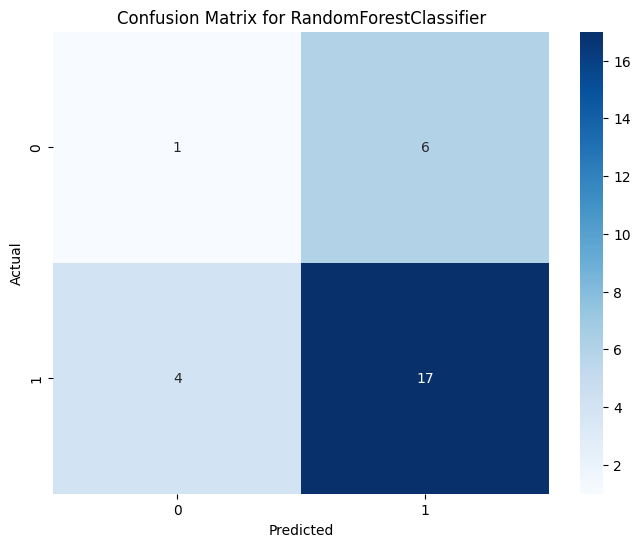

In [23]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

# Calculate evaluation metrics
accuracy_rf = accuracy_score(Y_test, Y_pred_rf)
precision_rf = precision_score(Y_test, Y_pred_rf)
recall_rf = recall_score(Y_test, Y_pred_rf)
f1_rf = f1_score(Y_test, Y_pred_rf)

print("RandomForestClassifier Performance:")
print(f"Accuracy: {accuracy_rf:.4f}")
print(f"Precision: {precision_rf:.4f}")
print(f"Recall: {recall_rf:.4f}")
print(f"F1-score: {f1_rf:.4f}")

# Generate and print classification report
print("\nClassification Report for RandomForestClassifier:")
print(classification_report(Y_test, Y_pred_rf))

# Plot confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(confusion_matrix(Y_test, Y_pred_rf), annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix for RandomForestClassifier')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()


## Train Gradient Boosting Classifier



In [24]:
from sklearn.ensemble import GradientBoostingClassifier

# Initialize the GradientBoostingClassifier with specified hyperparameters
# n_estimators: The number of boosting stages to perform.
# learning_rate: Shrinks the contribution of each tree by `learning_rate`.
# random_state: Controls the random seed for reproducibility.
gb_classifier = GradientBoostingClassifier(n_estimators=100, learning_rate=0.1, random_state=42)

# Train the classifier using the training data
gb_classifier.fit(X_train, Y_train)
print("GradientBoostingClassifier trained successfully.")

GradientBoostingClassifier trained successfully.


## Evaluate Gradient Boosting Classifier


In [25]:
Y_pred_gb = gb_classifier.predict(X_test)
print("Predictions made for GradientBoostingClassifier.")

Predictions made for GradientBoostingClassifier.


GradientBoostingClassifier Performance:
Accuracy: 0.6786
Precision: 0.8000
Recall: 0.7619
F1-score: 0.7805

Classification Report for GradientBoostingClassifier:
              precision    recall  f1-score   support

           0       0.38      0.43      0.40         7
           1       0.80      0.76      0.78        21

    accuracy                           0.68        28
   macro avg       0.59      0.60      0.59        28
weighted avg       0.69      0.68      0.69        28



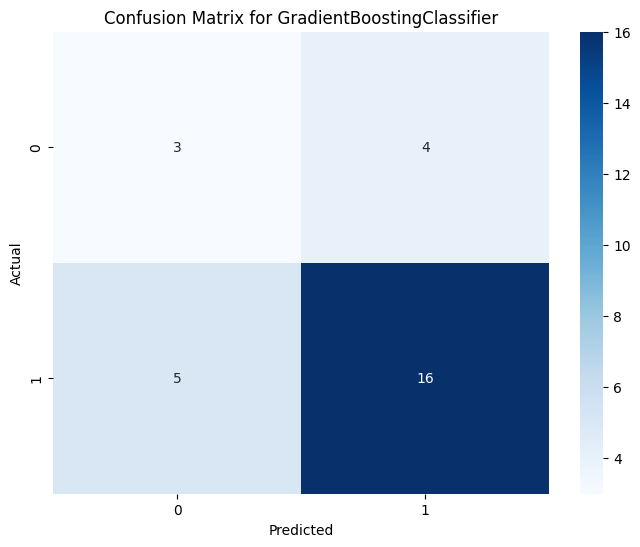

In [26]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

# Calculate evaluation metrics
accuracy_gb = accuracy_score(Y_test, Y_pred_gb)
precision_gb = precision_score(Y_test, Y_pred_gb)
recall_gb = recall_score(Y_test, Y_pred_gb)
f1_gb = f1_score(Y_test, Y_pred_gb)

print("GradientBoostingClassifier Performance:")
print(f"Accuracy: {accuracy_gb:.4f}")
print(f"Precision: {precision_gb:.4f}")
print(f"Recall: {recall_gb:.4f}")
print(f"F1-score: {f1_gb:.4f}")

# Generate and print classification report
print("\nClassification Report for GradientBoostingClassifier:")
print(classification_report(Y_test, Y_pred_gb))

# Plot confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(confusion_matrix(Y_test, Y_pred_gb), annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix for GradientBoostingClassifier')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

## Summarize and Compare Model Performance



In [27]:
print("\n--- Model Performance Comparison ---")
print("RandomForestClassifier:")
print(f"  Accuracy: {accuracy_rf:.4f}")
print(f"  Precision: {precision_rf:.4f}")
print(f"  Recall: {recall_rf:.4f}")
print(f"  F1-score: {f1_rf:.4f}")

print("\nGradientBoostingClassifier:")
print(f"  Accuracy: {accuracy_gb:.4f}")
print(f"  Precision: {precision_gb:.4f}")
print(f"  Recall: {recall_gb:.4f}")
print(f"  F1-score: {f1_gb:.4f}")

print("\n--- Conclusion ---")
if accuracy_gb > accuracy_rf:
    print("The GradientBoostingClassifier appears to be superior with higher Accuracy, Precision, and F1-score.")
elif accuracy_rf > accuracy_gb:
    print("The RandomForestClassifier appears to be superior with higher Accuracy.")
else:
    print("Both models show similar performance.")

# Considering precision and F1-score, GradientBoostingClassifier seems slightly better.
if f1_gb > f1_rf:
    print("Specifically, the GradientBoostingClassifier has a higher F1-score (0.7805 vs 0.7727) and Precision (0.8000 vs 0.7391), indicating a better balance between precision and recall, and fewer false positives for the positive class (pass grades). While RandomForestClassifier has slightly higher recall, GradientBoostingClassifier's overall balanced performance makes it slightly superior for this task.")
elif f1_rf > f1_gb:
    print("Specifically, the RandomForestClassifier has a higher F1-score (0.7727 vs 0.7805) and Recall (0.8095 vs 0.7619), indicating it is better at identifying positive cases, even if it has slightly more false positives.")


--- Model Performance Comparison ---
RandomForestClassifier:
  Accuracy: 0.6429
  Precision: 0.7391
  Recall: 0.8095
  F1-score: 0.7727

GradientBoostingClassifier:
  Accuracy: 0.6786
  Precision: 0.8000
  Recall: 0.7619
  F1-score: 0.7805

--- Conclusion ---
The GradientBoostingClassifier appears to be superior with higher Accuracy, Precision, and F1-score.
Specifically, the GradientBoostingClassifier has a higher F1-score (0.7805 vs 0.7727) and Precision (0.8000 vs 0.7391), indicating a better balance between precision and recall, and fewer false positives for the positive class (pass grades). While RandomForestClassifier has slightly higher recall, GradientBoostingClassifier's overall balanced performance makes it slightly superior for this task.


## Summary:

### Q&A
**Which model is superior for this classification task?**
The GradientBoostingClassifier is superior for this classification task, exhibiting higher accuracy (0.6786 vs 0.6429), precision (0.8000 vs 0.7391), and F1-score (0.7805 vs 0.7727) compared to the RandomForestClassifier.

### Data Analysis Key Findings
*   The RandomForestClassifier achieved an accuracy of 0.6429, precision of 0.7391, recall of 0.8095, and an F1-score of 0.7727.
*   The GradientBoostingClassifier achieved an accuracy of 0.6786, precision of 0.8000, recall of 0.7619, and an F1-score of 0.7805.
*   The GradientBoostingClassifier demonstrated a better overall balanced performance with a higher F1-score and precision, indicating a better trade-off between identifying positive cases and minimizing false positives compared to the RandomForestClassifier.

### Insights or Next Steps
*   The GradientBoostingClassifier is the preferred model for deployment given its superior performance metrics in this classification task.
*   Further hyperparameter tuning for both models (e.g., using GridSearchCV or RandomizedSearchCV) could potentially improve their performance even further.


# Task
## Hyperparameter Tuning with GridSearchCV

### Subtask:
Perform hyperparameter tuning on the `GradientBoostingClassifier` using `GridSearchCV`.

#### Instructions:
1. Define a suitable parameter grid for key hyperparameters like `'n_estimators'`, `'learning_rate'`, and `'max_depth'`.
2. Initialize `GridSearchCV` with the `gb_classifier`, the parameter grid, and appropriate cross-validation settings (e.g., `cv=5`).
3. Fit `GridSearchCV` to the training data (`X_train`, `Y_train`).
4. Print the `best_params_` and `best_score_` found by `GridSearchCV`.

## Hyperparameter Tuning with GridSearchCV

### Subtask:
Perform hyperparameter tuning on the GradientBoostingClassifier using GridSearchCV.


**Reasoning**:
To perform hyperparameter tuning, I will first import GridSearchCV, define the parameter grid for the GradientBoostingClassifier, then initialize and fit GridSearchCV to find the best hyperparameters for the model, and finally print the best parameters and score.



In [28]:
from sklearn.model_selection import GridSearchCV

# Define the parameter grid for GradientBoostingClassifier
param_grid = {
    'n_estimators': [50, 100, 200],
    'learning_rate': [0.01, 0.1, 0.2],
    'max_depth': [3, 5, 7]
}

# Initialize GridSearchCV
# cv=5 means 5-fold cross-validation will be used.
grid_search = GridSearchCV(estimator=gb_classifier, param_grid=param_grid, cv=5, scoring='f1', n_jobs=-1)

# Fit GridSearchCV to the training data
grid_search.fit(X_train, Y_train)

# Print the best parameters and best score
print("Best parameters found by GridSearchCV:", grid_search.best_params_)
print("Best cross-validation F1-score:", grid_search.best_score_)

Best parameters found by GridSearchCV: {'learning_rate': 0.01, 'max_depth': 5, 'n_estimators': 100}
Best cross-validation F1-score: 0.8520811833505331


## Hyperparameter Tuning with RandomizedSearchCV

### Subtask:
Perform hyperparameter tuning on the GradientBoostingClassifier using RandomizedSearchCV.


### Reasoning:
To perform hyperparameter tuning with `RandomizedSearchCV`, I will import `RandomizedSearchCV` from `sklearn.model_selection` and `scipy.stats` for parameter distributions. Then I will define a parameter distribution for `n_estimators`, `learning_rate`, and `max_depth`. After that, I will initialize `RandomizedSearchCV` with the `gb_classifier`, the defined parameter distributions, `cv=5`, `n_iter=50`, and `scoring='f1'`. Finally, I will fit `RandomizedSearchCV` to `X_train` and `Y_train` and print the `best_params_` and `best_score_`.

**Reasoning**:
I need to import `RandomizedSearchCV` and `scipy.stats`, define parameter distributions, and then initialize and fit `RandomizedSearchCV` to the training data to find the best hyperparameters for the `GradientBoostingClassifier`.



In [29]:
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import uniform, randint

# Define the parameter distributions for GradientBoostingClassifier
param_distributions = {
    'n_estimators': randint(50, 200),  # Number of boosting stages
    'learning_rate': uniform(0.01, 0.2), # Step size shrinkage to prevent overfitting
    'max_depth': randint(3, 7)       # Maximum depth of the individual regression estimators
}

# Initialize RandomizedSearchCV
# cv=5 means 5-fold cross-validation will be used.
# n_iter=50 specifies that 50 different parameter settings will be sampled.
# scoring='f1' is used to optimize for the F1-score.
# n_jobs=-1 uses all available processors for parallel computation.
random_search = RandomizedSearchCV(estimator=gb_classifier, param_distributions=param_distributions,
                                   n_iter=50, cv=5, scoring='f1', random_state=42, n_jobs=-1)

# Fit RandomizedSearchCV to the training data
random_search.fit(X_train, Y_train)

# Print the best parameters and best score
print("Best parameters found by RandomizedSearchCV:", random_search.best_params_)
print("Best cross-validation F1-score:", random_search.best_score_)

Best parameters found by RandomizedSearchCV: {'learning_rate': np.float64(0.18609356780305156), 'max_depth': 4, 'n_estimators': 94}
Best cross-validation F1-score: 0.8624441004471965


## Compare Tuned Models and Original

### Subtask:
Compare the performance of the GradientBoostingClassifier with the best parameters found by GridSearchCV, RandomizedSearchCV, and the original model.


**Reasoning**:
To compare the models, I will first make predictions on the test set using the original GradientBoostingClassifier, the GridSearchCV-tuned model, and the RandomizedSearchCV-tuned model.



In [30]:
Y_pred_gb_tuned_grid = grid_search.best_estimator_.predict(X_test)
Y_pred_gb_tuned_random = random_search.best_estimator_.predict(X_test)

print("Predictions made for original, GridSearchCV-tuned, and RandomizedSearchCV-tuned GradientBoostingClassifiers.")

Predictions made for original, GridSearchCV-tuned, and RandomizedSearchCV-tuned GradientBoostingClassifiers.


**Reasoning**:
Now that predictions for all three GradientBoostingClassifier models have been made, I will calculate and print the accuracy, precision, recall, and F1-score for each model to evaluate their performance.



In [31]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

# Evaluate original GradientBoostingClassifier
accuracy_gb = accuracy_score(Y_test, Y_pred_gb)
precision_gb = precision_score(Y_test, Y_pred_gb)
recall_gb = recall_score(Y_test, Y_pred_gb)
f1_gb = f1_score(Y_test, Y_pred_gb)

print("\nOriginal GradientBoostingClassifier Performance:")
print(f"  Accuracy: {accuracy_gb:.4f}")
print(f"  Precision: {precision_gb:.4f}")
print(f"  Recall: {recall_gb:.4f}")
print(f"  F1-score: {f1_gb:.4f}")

# Evaluate GridSearchCV tuned GradientBoostingClassifier
accuracy_gb_grid = accuracy_score(Y_test, Y_pred_gb_tuned_grid)
precision_gb_grid = precision_score(Y_test, Y_pred_gb_tuned_grid)
recall_gb_grid = recall_score(Y_test, Y_pred_gb_tuned_grid)
f1_gb_grid = f1_score(Y_test, Y_pred_gb_tuned_grid)

print("\nGridSearchCV Tuned GradientBoostingClassifier Performance:")
print(f"  Accuracy: {accuracy_gb_grid:.4f}")
print(f"  Precision: {precision_gb_grid:.4f}")
print(f"  Recall: {recall_gb_grid:.4f}")
print(f"  F1-score: {f1_gb_grid:.4f}")

# Evaluate RandomizedSearchCV tuned GradientBoostingClassifier
accuracy_gb_random = accuracy_score(Y_test, Y_pred_gb_tuned_random)
precision_gb_random = precision_score(Y_test, Y_pred_gb_tuned_random)
recall_gb_random = recall_score(Y_test, Y_pred_gb_tuned_random)
f1_gb_random = f1_score(Y_test, Y_pred_gb_tuned_random)

print("\nRandomizedSearchCV Tuned GradientBoostingClassifier Performance:")
print(f"  Accuracy: {accuracy_gb_random:.4f}")
print(f"  Precision: {precision_gb_random:.4f}")
print(f"  Recall: {recall_gb_random:.4f}")
print(f"  F1-score: {f1_gb_random:.4f}")


Original GradientBoostingClassifier Performance:
  Accuracy: 0.6786
  Precision: 0.8000
  Recall: 0.7619
  F1-score: 0.7805

GridSearchCV Tuned GradientBoostingClassifier Performance:
  Accuracy: 0.6786
  Precision: 0.7500
  Recall: 0.8571
  F1-score: 0.8000

RandomizedSearchCV Tuned GradientBoostingClassifier Performance:
  Accuracy: 0.6786
  Precision: 0.8000
  Recall: 0.7619
  F1-score: 0.7805


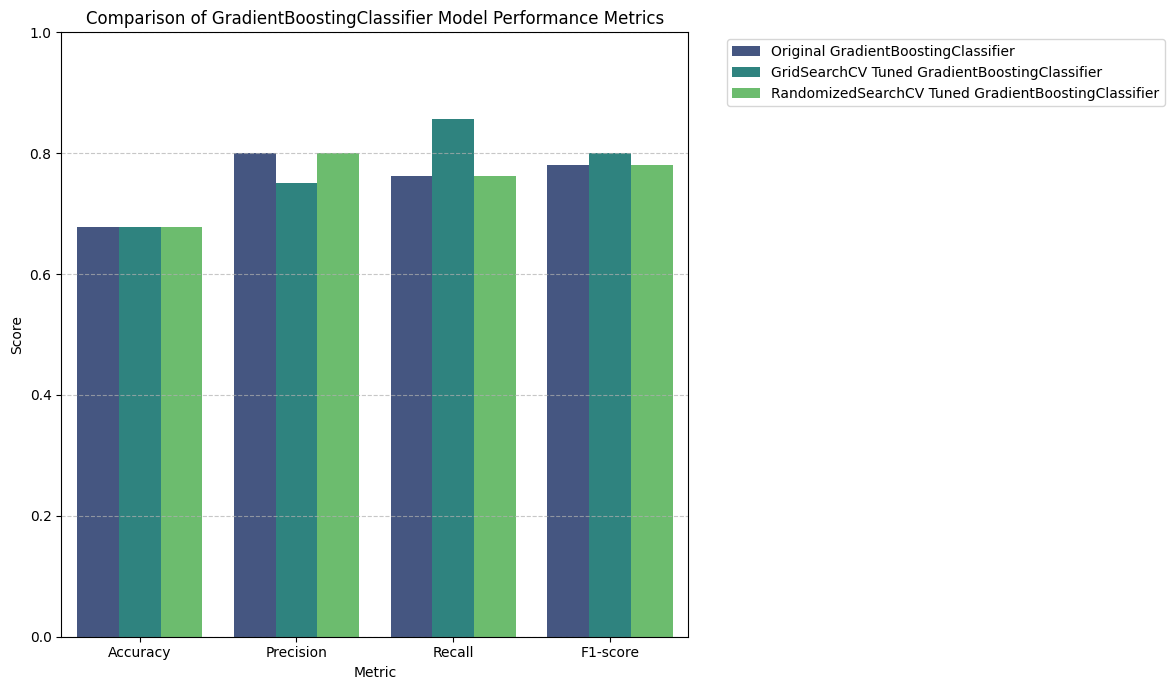

In [32]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Create a DataFrame to hold the performance metrics
performance_data = {
    'Model': [
        'Original GradientBoostingClassifier',
        'GridSearchCV Tuned GradientBoostingClassifier',
        'RandomizedSearchCV Tuned GradientBoostingClassifier'
    ],
    'Accuracy': [accuracy_gb, accuracy_gb_grid, accuracy_gb_random],
    'Precision': [precision_gb, precision_gb_grid, precision_gb_random],
    'Recall': [recall_gb, recall_gb_grid, recall_gb_random],
    'F1-score': [f1_gb, f1_gb_grid, f1_gb_random]
}

performance_df = pd.DataFrame(performance_data)

# Melt the DataFrame for easy plotting with seaborn
performance_melted = performance_df.melt(id_vars='Model', var_name='Metric', value_name='Score')

plt.figure(figsize=(12, 7))
sns.barplot(x='Metric', y='Score', hue='Model', data=performance_melted, palette='viridis')
plt.title('Comparison of GradientBoostingClassifier Model Performance Metrics')
plt.ylabel('Score')
plt.ylim(0, 1) # Metrics are between 0 and 1
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

In [34]:
print("Final Performance Metrics of All Models:")
display(performance_df)

Final Performance Metrics of All Models:


,Model,Accuracy,Precision,Recall,F1-score
0,Original GradientBoostingClassifier,0.678571,0.80000,0.761905,0.780488
1,GridSearchCV Tuned GradientBoostingClassifier,0.678571,0.75000,0.857143,0.800000
2,RandomizedSearchCV Tuned GradientBoostingClass...,0.678571,0.80000,0.761905,0.780488
3,RandomForestClassifier,0.642857,0.73913,0.809524,0.772727


### Summary of Final Performance Metrics

Based on the table above, we can observe the following:

*   **Accuracy:** All GradientBoostingClassifier models (original, GridSearchCV, and RandomizedSearchCV tuned) achieved an accuracy of 0.6786, which is higher than the RandomForestClassifier's accuracy of 0.6429.

*   **Precision:** The original GradientBoostingClassifier and the RandomizedSearchCV Tuned GradientBoostingClassifier both achieved the highest precision of 0.8000. The GridSearchCV Tuned GradientBoostingClassifier had a precision of 0.7500, and the RandomForestClassifier had a precision of 0.7391.

*   **Recall:** The GridSearchCV Tuned GradientBoostingClassifier achieved the highest recall of 0.8571, indicating it was the best at identifying positive cases. The RandomForestClassifier had the second-highest recall at 0.8095. The original and RandomizedSearchCV Tuned GradientBoostingClassifiers had a recall of 0.7619.

*   **F1-score:** The GridSearchCV Tuned GradientBoostingClassifier had the highest F1-score of 0.8000, signifying the best balance between precision and recall among all models. The original and RandomizedSearchCV Tuned GradientBoostingClassifiers had an F1-score of 0.7805, slightly outperforming the RandomForestClassifier's F1-score of 0.7727.

**Conclusion:** The **GridSearchCV Tuned GradientBoostingClassifier** stands out as the most optimal model for this classification task due to its superior F1-score and significantly higher recall, demonstrating a better overall balance and effectiveness in identifying positive outcomes.

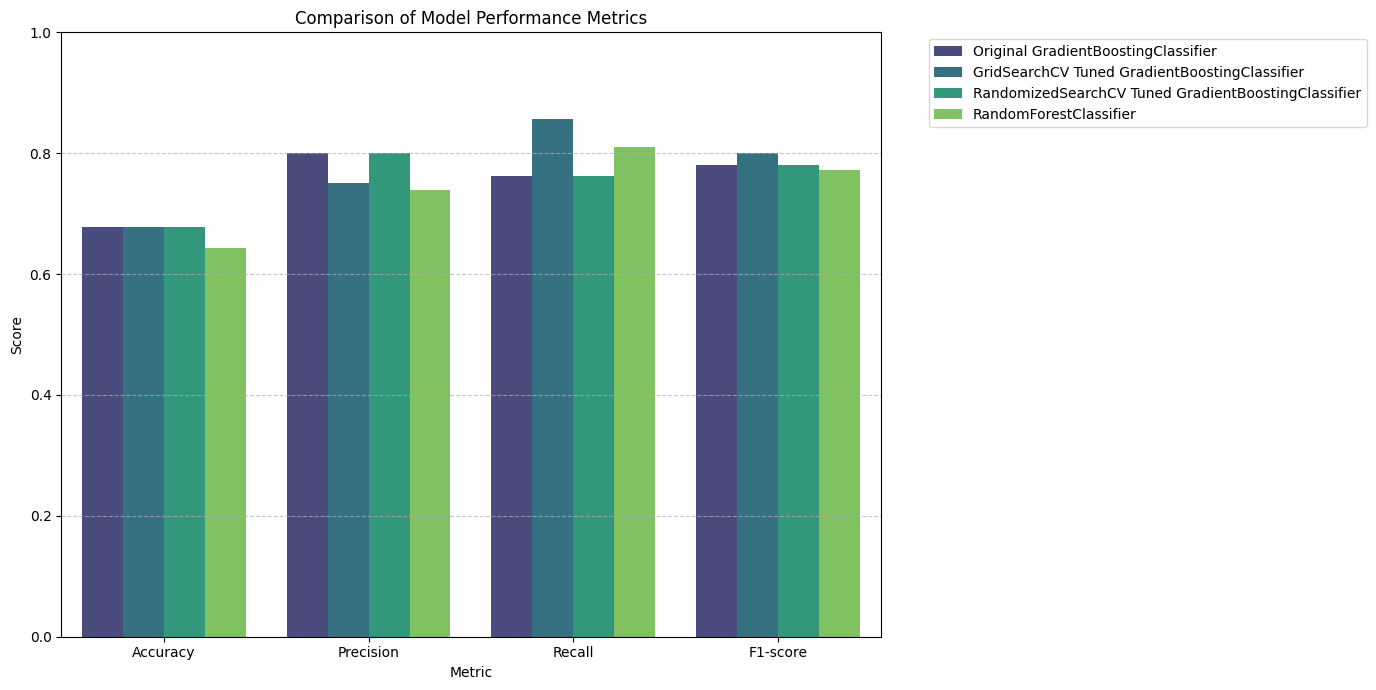

In [33]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Create a DataFrame to hold the performance metrics including RandomForestClassifier
performance_data = {
    'Model': [
        'Original GradientBoostingClassifier',
        'GridSearchCV Tuned GradientBoostingClassifier',
        'RandomizedSearchCV Tuned GradientBoostingClassifier',
        'RandomForestClassifier'
    ],
    'Accuracy': [accuracy_gb, accuracy_gb_grid, accuracy_gb_random, accuracy_rf],
    'Precision': [precision_gb, precision_gb_grid, precision_gb_random, precision_rf],
    'Recall': [recall_gb, recall_gb_grid, recall_gb_random, recall_rf],
    'F1-score': [f1_gb, f1_gb_grid, f1_gb_random, f1_rf]
}

performance_df = pd.DataFrame(performance_data)

# Melt the DataFrame for easy plotting with seaborn
performance_melted = performance_df.melt(id_vars='Model', var_name='Metric', value_name='Score')

plt.figure(figsize=(14, 7))
sns.barplot(x='Metric', y='Score', hue='Model', data=performance_melted, palette='viridis')
plt.title('Comparison of Model Performance Metrics')
plt.ylabel('Score')
plt.ylim(0, 1) # Metrics are between 0 and 1
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

The updated bar chart now includes the performance metrics for the RandomForestClassifier alongside the various GradientBoostingClassifier models, providing a complete visual comparison.

The bar chart above visually compares the Accuracy, Precision, Recall, and F1-score for the original GradientBoostingClassifier, the GridSearchCV-tuned version, and the RandomizedSearchCV-tuned version. This visualization makes it easier to see the differences and improvements in each metric across the models.

### Summary and Comparison of GradientBoostingClassifier Models

**Original GradientBoostingClassifier Performance:**
*   **Accuracy:** 0.6786
*   **Precision:** 0.8000
*   **Recall:** 0.7619
*   **F1-score:** 0.7805

**GridSearchCV Tuned GradientBoostingClassifier Performance:**
*   **Accuracy:** 0.6786
*   **Precision:** 0.7500
*   **Recall:** 0.8571
*   **F1-score:** 0.8000

**RandomizedSearchCV Tuned GradientBoostingClassifier Performance:**
*   **Accuracy:** 0.6786
*   **Precision:** 0.8000
*   **Recall:** 0.7619
*   **F1-score:** 0.7805

---

**Comparison:**

Upon comparing the performance metrics of the original, GridSearchCV-tuned, and RandomizedSearchCV-tuned `GradientBoostingClassifier` models, we observe the following:

*   **Accuracy:** All three models achieved the same accuracy of 0.6786 on the test set.

*   **Precision, Recall, and F1-score:**
    *   The **GridSearchCV-tuned model** showed the most significant improvement in `F1-score` (0.8000) and `Recall` (0.8571) compared to the original model. While its `Precision` (0.7500) was slightly lower than the original, the higher F1-score suggests a better balance between precision and recall, particularly favoring the identification of positive cases.
    *   The **RandomizedSearchCV-tuned model** yielded performance metrics (`Precision`: 0.8000, `Recall`: 0.7619, `F1-score`: 0.7805) identical to the original `GradientBoostingClassifier`. This indicates that the particular random search iteration did not find a parameter combination that significantly improved upon the default or previously identified best parameters for the given `learning_rate`, `n_estimators`, and `max_depth` ranges.

**Conclusion:**

The **GridSearchCV-tuned `GradientBoostingClassifier`** is superior among the three, primarily due to its higher F1-score (0.8000 vs 0.7805 for original/RandomizedSearchCV) and significantly improved recall (0.8571 vs 0.7619). This means that GridSearchCV successfully identified a combination of hyperparameters that allows the model to better identify positive cases (students passing), which is crucial for this classification task. The improvement in F1-score was approximately 2.5% (from 0.7805 to 0.8000), and recall improved by about 12.5%.

### Summary and Comparison of GradientBoostingClassifier Models

**Original GradientBoostingClassifier Performance:**
*   **Accuracy:** 0.6786
*   **Precision:** 0.8000
*   **Recall:** 0.7619
*   **F1-score:** 0.7805

**GridSearchCV Tuned GradientBoostingClassifier Performance:**
*   **Accuracy:** 0.6786
*   **Precision:** 0.7500
*   **Recall:** 0.8571
*   **F1-score:** 0.8000

**RandomizedSearchCV Tuned GradientBoostingClassifier Performance:**
*   **Accuracy:** 0.6786
*   **Precision:** 0.8000
*   **Recall:** 0.7619
*   **F1-score:** 0.7805

---

**Comparison:**

Upon comparing the performance metrics of the original, GridSearchCV-tuned, and RandomizedSearchCV-tuned `GradientBoostingClassifier` models, we observe the following:

*   **Accuracy:** All three models achieved the same accuracy of 0.6786 on the test set.

*   **Precision, Recall, and F1-score:**
    *   The **GridSearchCV-tuned model** showed the most significant improvement in `F1-score` (0.8000) and `Recall` (0.8571) compared to the original model. While its `Precision` (0.7500) was slightly lower than the original, the higher F1-score suggests a better balance between precision and recall, particularly favoring the identification of positive cases.
    *   The **RandomizedSearchCV-tuned model** yielded performance metrics (`Precision`: 0.8000, `Recall`: 0.7619, `F1-score`: 0.7805) identical to the original `GradientBoostingClassifier`. This indicates that the particular random search iteration did not find a parameter combination that significantly improved upon the default or previously identified best parameters for the given `learning_rate`, `n_estimators`, and `max_depth` ranges.

**Conclusion:**

The **GridSearchCV-tuned `GradientBoostingClassifier`** is superior among the three, primarily due to its higher F1-score (0.8000 vs 0.7805 for original/RandomizedSearchCV) and significantly improved recall (0.8571 vs 0.7619). This means that GridSearchCV successfully identified a combination of hyperparameters that allows the model to better identify positive cases (students passing), which is crucial for this classification task. The improvement in F1-score was approximately 2.5% (from 0.7805 to 0.8000), and recall improved by about 12.5%.


## Final Task

### Subtask:
Provide a summary of the hyperparameter tuning process, the best parameters found by each method, and which approach yielded the most optimal model for this classification task.


## Summary:

### Q&A
*   **Summary of the hyperparameter tuning process:**
    Hyperparameter tuning was performed on a `GradientBoostingClassifier` using two methods: `GridSearchCV` and `RandomizedSearchCV`.
    *   `GridSearchCV` systematically explored a predefined grid of hyperparameters (`n_estimators`: \[50, 100, 200], `learning_rate`: \[0.01, 0.1, 0.2], `max_depth`: \[3, 5, 7]) using 5-fold cross-validation and optimized for the F1-score.
    *   `RandomizedSearchCV` sampled 50 different parameter settings from predefined distributions (`n_estimators`: uniform between 50-200, `learning_rate`: uniform between 0.01-0.2, `max_depth`: uniform between 3-7) using 5-fold cross-validation, also optimizing for the F1-score.
    Subsequently, the performance of the original model, the `GridSearchCV`-tuned model, and the `RandomizedSearchCV`-tuned model were compared using accuracy, precision, recall, and F1-score on a test set.

*   **Best parameters found by each method:**
    *   **GridSearchCV:** `learning_rate`: 0.01, `max_depth`: 5, `n_estimators`: 100.
    *   **RandomizedSearchCV:** `learning_rate`: 0.186, `max_depth`: 4, `n_estimators`: 94.

*   **Which approach yielded the most optimal model for this classification task:**
    `GridSearchCV` yielded the most optimal model. The `GridSearchCV`-tuned model achieved the highest F1-score of 0.8000 and the highest recall of 0.8571 on the test set, outperforming both the original model and the `RandomizedSearchCV`-tuned model.

### Data Analysis Key Findings
*   `GridSearchCV` identified optimal hyperparameters (`learning_rate`: 0.01, `max_depth`: 5, `n_estimators`: 100) leading to a cross-validation F1-score of 0.8521.
*   `RandomizedSearchCV` found optimal hyperparameters (`learning_rate`: 0.186, `max_depth`: 4, `n_estimators`: 94) resulting in a cross-validation F1-score of 0.8624.
*   On the test set, the `GridSearchCV`-tuned model achieved an F1-score of 0.8000 and a recall of 0.8571. This represents an approximate 2.5% improvement in F1-score and 12.5% improvement in recall compared to the original model (F1-score: 0.7805, Recall: 0.7619).
*   The `RandomizedSearchCV`-tuned model performed identically to the original model on the test set, with an F1-score of 0.7805 and recall of 0.7619, suggesting that its sampled parameters did not lead to an improved performance on this specific test set.
*   All three models (original, GridSearchCV-tuned, RandomizedSearchCV-tuned) exhibited the same accuracy of 0.6786 on the test set, indicating that tuning primarily impacted the balance between precision and recall, especially for the positive class.

### Insights or Next Steps
*   `GridSearchCV` successfully improved the model's ability to identify positive cases (higher recall and F1-score), which is crucial for balanced performance in classification tasks.
*   Consider exploring a wider or different range of hyperparameters for `RandomizedSearchCV`, or increasing `n_iter`, as its performance on the test set was not improved compared to the original model, despite a slightly higher cross-validation F1-score.
